# Evaluation of the prevalence of single-maintainer packages

In [ ]:
%matplotlib inline

import sys
print(f'Python {sys.version}')

import IPython
print(f'IPython {IPython.__version__}')

print('\nLibraries:\n')

import matplotlib
import matplotlib.pyplot as plt
print(f'matplotlib {matplotlib.__version__}')

import numpy as np
print(f'numpy {np.__version__}')

import pandas as pd
from pandas.plotting import register_matplotlib_converters
print(f'pandas {pd.__version__}')

import requests
print(f'requests {requests.__version__}')

import scipy
from scipy.optimize import curve_fit
print(f'scipy {scipy.__version__}')

Python 3.7.3 (default, Mar 25 2019, 20:59:09) 
[GCC 7.4.0]
IPython 7.2.0

Libraries:

matplotlib 3.0.3
numpy 1.16.1
pandas 0.24.1
requests 2.21.0
scipy 1.2.1


In [ ]:
plt.rcParams.update({
    'figure.figsize': [7, 7],
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.titlesize': 8,
    'legend.frameon': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'lines.linewidth': 1,
    'figure.dpi': 150.0
})

register_matplotlib_converters()

## Data pre-processing and generation of smaller datasets

This section is computationally intensive and can be skipped by reusing saved pre-processed datasets.

### Load package with repository information from Libraries.io dataset

In [ ]:
packages = pd.read_csv(
    'libraries-1.4.0-2018-12-22/projects_with_repository_fields-1.4.0-2018-12-22.csv.gz',
    index_col=False,
    usecols=[
        'ID',
        'Platform',
        'Dependent Repositories Count',
        'Repository Name with Owner',
        'Repository Last pushed Timestamp',
        'Repository Size',
        'Repository Contributors Count'
    ],
    dtype={
        'Platform': 'category',
        'ID': 'uint32',
        'Dependent Repositories Count': 'uint16',
        'Repository Size':'UInt32',
        'Repository Contributors Count':'UInt16'
    }
)

This dataset holds more than 3,000,000 packages.

In [ ]:
len(packages)

3343746

These are the platforms on which these packages are published:

In [ ]:
packages.assign(Count=1).groupby('Platform',observed=True).count()[['Count']].sort_values('Count',ascending=False)

,Count
Platform,
Go,1141005
NPM,926662
Packagist,251193
Maven,198104
Pypi,172507
Rubygems,152154
NuGet,135569
Bower,69002
Wordpress,59824


There are only 2,500,000 packages (those located on GitHub) on which all of the columns we selected have defined values.

In [ ]:
packages.dropna(inplace=True)
len(packages)

2503923

### Extract packages with at least two reverse dependencies from Libraries.io dataset

This will reduce from the start the size of the data that we are handling. In practice, we want a stronger criterion since there must be at least two actively maintained reverse dependencies, from different owners. Note that we also wanted to restrict this criterion to direct dependencies, but due to the way dependencies are computed by Libraries.io (from lockfiles when they exist), in many case the dependencies include transitive dependencies.

Additionally, we also filter trivial packages out based on repository size.

In [ ]:
# Filter based on number of reverse dependencies
filtered_packages = packages[packages['Dependent Repositories Count']>1]
# Filter based on repository size
filtered_packages = filtered_packages[filtered_packages['Repository Size']>10]
# Parse date faster: we do not care about the exact time
filtered_packages['Repository Last pushed Timestamp'] = filtered_packages['Repository Last pushed Timestamp'].apply(lambda x: pd.to_datetime(str(x)[:10]))
# Extract owner information
filtered_packages['Owner'] = filtered_packages['Repository Name with Owner'].apply(lambda s: s.split('/',maxsplit=1)[0])

We have reduced the number of packages that we consider by more than a factor 10, from about 3,400,000 to about 260,000.

In [ ]:
len(filtered_packages)

257471

In [ ]:
filtered_packages = filtered_packages.set_index('ID')

In [ ]:
filtered_packages.assign(Count=1).groupby('Platform',observed=True).count()[['Count']].sort_values('Count',ascending=False)

,Count
Platform,
NPM,116023
Packagist,29297
Rubygems,22432
Pypi,18701
Maven,18035
Bower,13265
NuGet,10130
Go,9562
CocoaPods,6842


### Extract active repositories from Libraries.io dataset

We keep only those repositories that were pushed to in the last six months before the Libraries.io dataset was released. We save them in a new CSV file for easy retrieval and reuse.

In [ ]:
chunks = pd.read_csv(
    'libraries-1.4.0-2018-12-22/repositories-1.4.0-2018-12-22.csv.gz',
    index_col=False,
    usecols=['ID','Last pushed Timestamp'],
    chunksize=1000000
)

In [ ]:
chunk_list = []
i = 0
min_date=pd.datetime(2018,6,22)
for chunk in chunks:
    i += 1
    print(f'Chunk {i}')
    # Parse date faster: we do not care about the exact time
    chunk['Last pushed Timestamp'] = chunk['Last pushed Timestamp'].apply(lambda x: pd.to_datetime(str(x)[:10]))
    # Filter based on last push date
    chunk = chunk[chunk['Last pushed Timestamp'] > min_date]
    print(f'Chunk size after filtering: {len(chunk)}')
    chunk_list.append(chunk)

Chunk 1
Chunk size after filtering: 29143
Chunk 2
Chunk size after filtering: 6778
Chunk 3
Chunk size after filtering: 5723
Chunk 4
Chunk size after filtering: 4723
Chunk 5
Chunk size after filtering: 1755
Chunk 6
Chunk size after filtering: 3505
Chunk 7
Chunk size after filtering: 1081
Chunk 8
Chunk size after filtering: 2405
Chunk 9
Chunk size after filtering: 5638
Chunk 10
Chunk size after filtering: 3946
Chunk 11
Chunk size after filtering: 4067
Chunk 12
Chunk size after filtering: 3185
Chunk 13
Chunk size after filtering: 3715
Chunk 14
Chunk size after filtering: 3747
Chunk 15
Chunk size after filtering: 3102
Chunk 16
Chunk size after filtering: 2393
Chunk 17
Chunk size after filtering: 2486
Chunk 18
Chunk size after filtering: 2650
Chunk 19
Chunk size after filtering: 3584
Chunk 20
Chunk size after filtering: 3519
Chunk 21
Chunk size after filtering: 4049
Chunk 22
Chunk size after filtering: 3975
Chunk 23
Chunk size after filtering: 4613
Chunk 24
Chunk size after filtering: 3667


We have reduced the size of the dataset from about 34,000,000 repositories to about 800,000 repositories.

In [ ]:
active_repositories = pd.concat(chunk_list)
len(active_repositories)

807174

In [ ]:
active_repositories

,ID,Last pushed Timestamp
8,9,2018-12-19
58,76,2018-11-05
92,110,2018-10-02
98,116,2018-12-22
155,176,2018-07-15
159,180,2018-12-17
209,233,2018-11-19
210,234,2018-12-11
217,241,2018-09-22
263,294,2018-12-17


### Extract popular packages these active repositories depend on

We now consider the dependencies from one of our previously defined actively maintained repository, to one of our previously filtered package. The goal is to be able to restrict further the list of packages to those that are depended upon by two active repositories of different owners.

In [ ]:
chunks = pd.read_csv(
    'libraries-1.4.0-2018-12-22/repository_dependencies-1.4.0-2018-12-22.csv.gz',
    index_col=False,
    usecols=['Repository Name with Owner','Repository ID','Dependency Project ID'],
    dtype={'Repository ID': 'uint32', 'Dependency Project ID': 'UInt32'},
    chunksize=5000000
)

In [ ]:
chunk_list = []
i = 0
for chunk in chunks:
    i += 1
    print(f'Chunk {i}')
    # Keep only dependencies in our filtered packages dataset
    chunk = chunk[chunk['Dependency Project ID'].isin(filtered_packages['ID'])]
    # Keep only dependencies of active repositories
    chunk = chunk[chunk['Repository ID'].isin(active_repositories['ID'])]
    print(f'Chunk size after filtering: {len(chunk)}')
    # Extract owner information
    chunk['Owner'] = chunk['Repository Name with Owner'].map(lambda s: s.split('/',maxsplit=1)[0]).astype('category')
    # Drop duplicate owners (this is done later on the whole dataset but this could already improve the efficiency)
    #chunk = chunk.drop_duplicates(subset=['Dependency Project ID','Owner'])
    #print(f'Chunk size after removing duplicate owners: {len(chunk)}')
    chunk_list.append(chunk[['Dependency Project ID','Owner']])

Chunk 1
Chunk size after filtering: 112461
Chunk 2
Chunk size after filtering: 67380
Chunk 3
Chunk size after filtering: 212851
Chunk 4
Chunk size after filtering: 402265
Chunk 5
Chunk size after filtering: 402742
Chunk 6
Chunk size after filtering: 361279
Chunk 7
Chunk size after filtering: 392974
Chunk 8
Chunk size after filtering: 411531
Chunk 9
Chunk size after filtering: 641579
Chunk 10
Chunk size after filtering: 144603
Chunk 11
Chunk size after filtering: 189116
Chunk 12
Chunk size after filtering: 265814
Chunk 13
Chunk size after filtering: 368880
Chunk 14
Chunk size after filtering: 283003
Chunk 15
Chunk size after filtering: 227528
Chunk 16
Chunk size after filtering: 208717
Chunk 17
Chunk size after filtering: 202844
Chunk 18
Chunk size after filtering: 187627
Chunk 19
Chunk size after filtering: 191747
Chunk 20
Chunk size after filtering: 350548
Chunk 21
Chunk size after filtering: 194016
Chunk 22
Chunk size after filtering: 183220
Chunk 23
Chunk size after filtering: 24648

We have a first restricted list of about 73,000,000 dependencies (down from about 390,000,000).

In [ ]:
filtered_dependencies = pd.concat(chunk_list)
len(filtered_dependencies)

73502146

After removing duplicate owners, we are down to 33,000,000.

In [ ]:
filtered_dependencies = filtered_dependencies.drop_duplicates()
len(filtered_dependencies)

33166499

In [ ]:
filtered_dependencies.to_csv('preprocessed-data/filtered_dependencies.csv.gz')

In [ ]:
filtered_dependencies

,Dependency Project ID,Owner
30001271,615838,acarteas
30001273,625324,acarteas
30002019,141102,cocos-creator
30002020,279981,cocos-creator
30002021,281245,cocos-creator
30002022,287937,cocos-creator
30002023,570186,cocos-creator
30002024,287980,cocos-creator
30002025,288002,cocos-creator
30002027,155056,cocos-creator


In [ ]:
packages_active_dependent_owners = filtered_dependencies.groupby('Dependency Project ID',observed=True).agg({'Owner':'nunique'})

We are now down to about 65,000 popular packages that are depended upon by at least two active projects from distinct owners.

In [ ]:
filtered_packages = filtered_packages.join(packages_active_dependent_owners,rsuffix=' Dependent Count')
filtered_packages = filtered_packages[filtered_packages['Owner Dependent Count'] > 1]
len(filtered_packages)

64662

In [ ]:
filtered_packages

,ID,Dependent Repositories Count,Repository Name with Owner,Repository Last pushed Timestamp,Repository Size,Repository Contributors Count,Owner,Owner Dependent Count
0,287,36,DerelictOrg/DerelictFI,2017-06-04,54,5,DerelictOrg,2
1,289,106,DerelictOrg/DerelictGL3,2018-09-03,663,14,DerelictOrg,7
2,290,28,DerelictOrg/DerelictGLFW3,2017-06-04,73,4,DerelictOrg,3
3,297,94,DerelictOrg/DerelictSDL2,2018-08-21,459,18,DerelictOrg,9
4,300,73,DerelictOrg/DerelictUtil,2017-09-23,60,5,DerelictOrg,4
5,345,20,buggins/dlangui,2018-11-26,39058,40,buggins,2
6,346,17,gecko0307/dlib,2018-11-09,7979,15,gecko0307,2
7,374,39,dlang-community/D-YAML,2018-12-14,3680,21,dlang-community,3
8,403,38,Dav1dde/gl3n,2016-01-10,2035,14,Dav1dde,3
9,421,22,lgvz/imageformats,2018-04-14,282,5,lgvz,4


In [ ]:
filtered_packages.to_csv('preprocessed-data/filtered_packages.csv.gz')

## Analysis of filtered packages

This section can be executed without reexecuting the previous one provided that the preprocessed dataset has been saved and can be loaded.

In [ ]:
filtered_packages = pd.read_csv('preprocessed-data/filtered_packages.csv.gz')
filtered_packages['Repository Last pushed Timestamp'] = filtered_packages['Repository Last pushed Timestamp'].apply(lambda x: pd.to_datetime(str(x)[:10]))

### Pre-processing: remove zero-contributor packages

Zero-contributor packages are an oddity. Sometimes, they are due to GitHub users improperly configuring their account, and GitHub not recognizing the commit e-mail address, but by manually browsing some of these repositories, we have also noticed deleted repositories (404 errors), and repositories with many contributors whose information Libraries.io improperly fetched. Therefore, to avoid depending on incorrect data, we remove these packages from our dataset.

In [ ]:
filtered_packages[filtered_packages['Repository Contributors Count'] == 0]

,ID,Dependent Repositories Count,Repository Name with Owner,Repository Last pushed Timestamp,Repository Size,Repository Contributors Count,Owner,Owner Dependent Count
121,2217,177,marcoslin/bower-angularAMD,2015-11-06,224,0,marcoslin,2
378,8514,66,hoangductho/cryptojs,2015-08-08,248,0,hoangductho,2
1091,29933,12,Workiva/json_schema,2018-07-26,2444,0,Workiva,5
1362,31852,99,russellballestrini/ago,NaT,62,0,russellballestrini,3
1376,31978,8251,zzzeek/alembic,NaT,6058,0,zzzeek,319
1382,32162,2763,nielsenb/aniso8601,NaT,2059,0,nielsenb,228
1386,32187,152,jonathaneunice/colors,2017-06-02,48,0,jonathaneunice,7
1454,33417,322,wooster/biplist,NaT,1107,0,wooster,10
1476,33841,20,cmutel/brightway2,NaT,16829,0,cmutel,2
1489,34129,93,cyrilrbt/caldav,NaT,427,0,cyrilrbt,11


In [ ]:
filtered_packages = filtered_packages[filtered_packages['Repository Contributors Count'] > 0]
filtered_packages

,ID,Dependent Repositories Count,Repository Name with Owner,Repository Last pushed Timestamp,Repository Size,Repository Contributors Count,Owner,Owner Dependent Count
0,287,36,DerelictOrg/DerelictFI,2017-06-04,54,5,DerelictOrg,2
1,289,106,DerelictOrg/DerelictGL3,2018-09-03,663,14,DerelictOrg,7
2,290,28,DerelictOrg/DerelictGLFW3,2017-06-04,73,4,DerelictOrg,3
3,297,94,DerelictOrg/DerelictSDL2,2018-08-21,459,18,DerelictOrg,9
4,300,73,DerelictOrg/DerelictUtil,2017-09-23,60,5,DerelictOrg,4
5,345,20,buggins/dlangui,2018-11-26,39058,40,buggins,2
6,346,17,gecko0307/dlib,2018-11-09,7979,15,gecko0307,2
7,374,39,dlang-community/D-YAML,2018-12-14,3680,21,dlang-community,3
8,403,38,Dav1dde/gl3n,2016-01-10,2035,14,Dav1dde,3
9,421,22,lgvz/imageformats,2018-04-14,282,5,lgvz,4


### Pre-processing: count only one package per repository

Some repositories are used to develop multiple packages (sometimes just a main package and smaller satellite or test packages, but sometimes a single repository can be used to develop hundreds of packages).

The principal issue with these is that information like date of last push and contributor count will not correspond to the package itself but to the whole repository, thus a package may be wrongly considered maintained because of this, or the number of contributors to the package may be overestimated.

There are also packages that are published multiple times, either because the name of the package was changed, or because the package was published on multiple repositories (npm and Bower, PyPI and Homebrew...).

When a repository is associated with multiple package, it is hard to know whether the explanation is the first or the second one.

We avoid this problem by associating at most one package for each repository. When multiple such packages have ended up in our `filtered_packages` set, we select the one with the most dependent owners.

In [ ]:
filtered_packages = filtered_packages.assign(Count=1).groupby('Repository Name with Owner').agg({
    'Repository Last pushed Timestamp': 'first',
    'Repository Size': 'first',
    'Repository Contributors Count': 'first',
    'Owner': 'first',
    'Owner Dependent Count': 'max',
    'Count': 'count'
}).sort_values('Count',ascending=False)
filtered_packages

,Repository Last pushed Timestamp,Repository Size,Repository Contributors Count,Owner,Owner Dependent Count,Count
Repository Name with Owner,,,,,,
DefinitelyTyped/DefinitelyTyped,2018-12-19,391136,1117,DefinitelyTyped,23450,1581
babel/babel,2018-12-19,37286,644,babel,41169,286
lodash/lodash,2018-12-16,44182,268,lodash,47901,283
kubernetes/kubernetes,2018-12-23,819602,642,kubernetes,87,190
aws/aws-sdk-ruby,2018-12-23,70699,138,aws,299,174
ionic-team/ionic-native,2018-12-17,10782,469,ionic-team,671,118
Turfjs/turf,2018-10-10,41761,93,Turfjs,126,114
Azure/azure-sdk-for-node,2018-12-20,105719,172,Azure,34,94
lerna/lerna,2018-12-21,5450,204,lerna,1680,93


In [ ]:
len(filtered_packages[filtered_packages['Count'] > 1])

3270

### Define what it means for such package to be maintained

We consider the packages that have been pushed to in the last year before the dataset was published, and not just the last six months because it we want to consider only inactive packages that have not been pushed for six months before their reverse dependencies were updated.

In [ ]:
filtered_packages['Active'] = filtered_packages['Repository Last pushed Timestamp'] > pd.datetime(2017,12,22)

### First approximation: packages with only one contributor

This is a clear under-approximation since we are actually looking for packages with a single maintainer, not a single contributor. Yet, we get an impressive 9,000 such packages.

In [ ]:
popular_packages_with_a_single_contributor = filtered_packages[filtered_packages['Repository Contributors Count'] == 1]
len(popular_packages_with_a_single_contributor)

8980

which represents about 18% of all packages:

In [ ]:
len(popular_packages_with_a_single_contributor)/len(filtered_packages)

0.17877050485746138

And even with stronger criteria like the packages that are depended upon by 10 active projects from distinct owners, we still get large numbers:

In [ ]:
very_popular_packages = filtered_packages[filtered_packages['Owner Dependent Count'] >= 10]
very_popular_packages_with_a_single_contributor = very_popular_packages[very_popular_packages['Repository Contributors Count'] == 1]
len(very_popular_packages_with_a_single_contributor)

2497

This is still about 12% of all such packages:

In [ ]:
len(very_popular_packages_with_a_single_contributor)/len(very_popular_packages)

0.1242845054999751

67% of all the popular packages are actively maintained.

In [ ]:
len(filtered_packages[filtered_packages['Active']])/len(filtered_packages)

0.6753264851090938

But only 44% of the packages with only one contributor.

In [ ]:
len(popular_packages_with_a_single_contributor[popular_packages_with_a_single_contributor['Active']])/len(popular_packages_with_a_single_contributor)

0.44075723830734964

Among the very popular packages, the maintenance rate is slightly better:

In [ ]:
len(very_popular_packages[very_popular_packages['Active']])/len(very_popular_packages)

0.7139515205813548

But the maintenance rate for the subset with only one contributor is even worse:

In [ ]:
len(very_popular_packages_with_a_single_contributor[very_popular_packages_with_a_single_contributor['Active']])/len(very_popular_packages_with_a_single_contributor)

0.3444132959551462

### Stats on the relation between the number of contributors and other factors

In [ ]:
packages_by_number_of_contributor = filtered_packages.assign(Count=1).groupby('Repository Contributors Count').agg({
    'Count': 'count',
    'Active': 'mean'
})

Here we learn that the cumulative number of packages with at least x contributors decreases at exponential speed at first, and then only following a power law. We deduce that the first few contributors are the hardest to get.

In [ ]:
packages_by_number_of_contributor

,Count,Active
Repository Contributors Count,,
1,8980,0.440757
2,5984,0.539271
3,4419,0.572980
4,3431,0.625765
5,2683,0.657846
6,2361,0.686150
7,1929,0.707102
8,1631,0.734519
9,1476,0.762195


In [ ]:
cumsum = (len(filtered_packages) - packages_by_number_of_contributor['Count'].cumsum())[:100]

In [ ]:
def exp(x, a, b, c):
    return a*np.exp(-b*x) + c

def puiss(x, a, b):
    return a*np.power(x,-b)

def compute_rsquare(f, popt, xdata, ydata):
    residuals = ydata - f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata - np.mean(ydata))**2)
    return 1 - (ss_res / ss_tot), ss_res

def fit_curves(frontier):
    
    ydata_exp = cumsum[cumsum.index < frontier]
    ydata_puiss = cumsum[cumsum.index >= frontier]
    
    xdata_exp = ydata_exp.index
    xdata_puiss = ydata_puiss.index
    
    popt_exp, _ = curve_fit(exp, xdata_exp, ydata_exp, p0=(1000, 0.1,10))
    popt_puiss, _ = curve_fit(puiss, xdata_puiss, ydata_puiss, p0=(10,3.0))
    
    rsquare_exp, ss_res_exp = compute_rsquare(exp, popt_exp, xdata_exp, ydata_exp)
    rsquare_puiss, ss_res_puiss = compute_rsquare(puiss, popt_puiss, xdata_puiss, ydata_puiss)
    
    ss_tot_global = np.sum((cumsum - np.mean(cumsum))**2)
    rsquare_global = 1 - ((ss_res_exp + ss_res_puiss) / ss_tot_global)
    
    return rsquare_global, popt_exp, rsquare_exp, popt_puiss, rsquare_puiss

We choose the frontier that allows to best fit the two parts of the observed curve.

/nix/store/3a2a0mb1ad0p9jjfrwl0ynw2galh543x-python3.7-ipykernel-5.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/nix/store/3a2a0mb1ad0p9jjfrwl0ynw2galh543x-python3.7-ipykernel-5.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/nix/store/3a2a0mb1ad0p9jjfrwl0ynw2galh543x-python3.7-ipykernel-5.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/nix/store/3a2a0mb1ad0p9jjfrwl0ynw2galh543x-python3.7-ipykernel-5.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/nix/store/3a2a0mb1ad0p9jjfrwl0ynw2galh543x-python3.7-ipykernel-5.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/nix/store/3a2a0mb1ad0p9jjfrwl0ynw2galh543x-python3.7-ipykernel-5.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: Ru

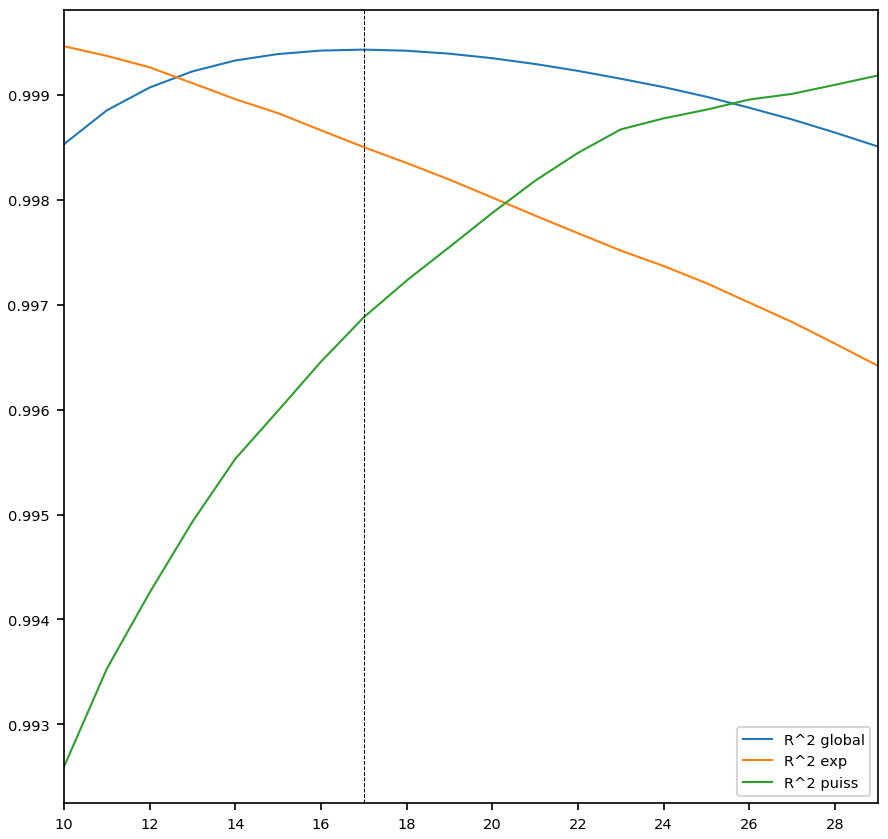

In [ ]:
fits = pd.DataFrame(columns=('R^2 global', 'popt_exp', 'R^2 exp', 'popt_puiss', 'R^2 puiss'))
for i in range(10,30):
    fits.loc[i] = fit_curves(i)
fits[['R^2 global', 'R^2 exp', 'R^2 puiss']].plot()

frontier = fits['R^2 global'].idxmax()
plt.axvline(frontier,linewidth=0.5,linestyle='--',color='black')

plt.xticks(range(10,30,2))
plt.show()

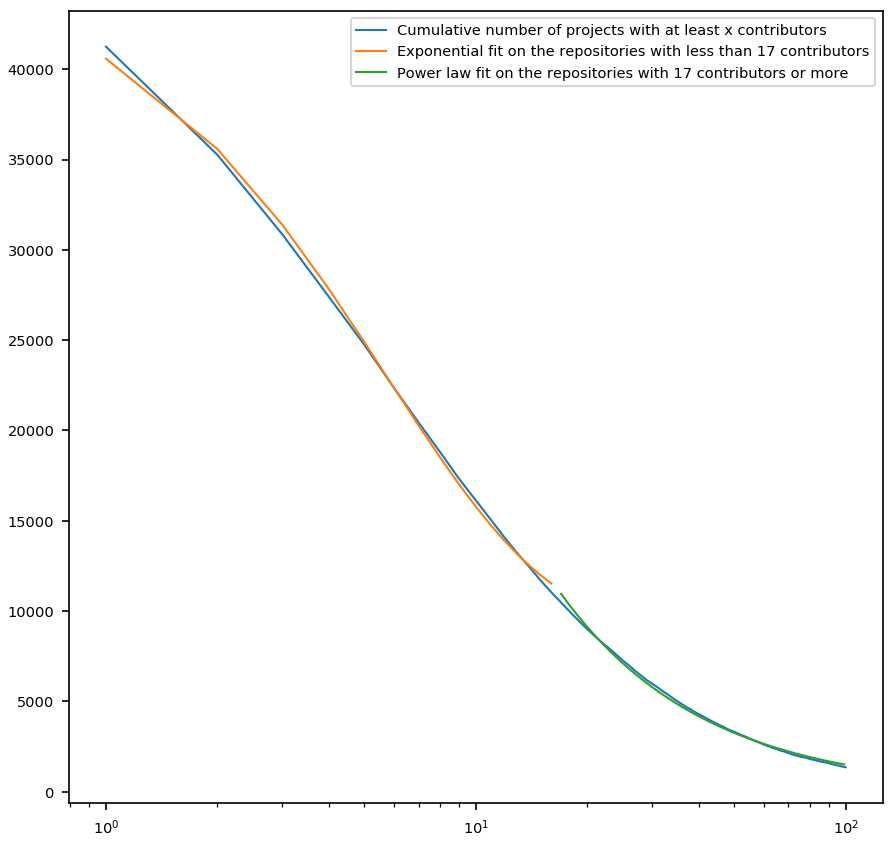

In [ ]:
frontier = 17
popt_exp = fits.loc[frontier,'popt_exp']
popt_puiss = fits.loc[frontier,'popt_puiss']

plt.plot(cumsum,label='Cumulative number of projects with at least x contributors')
plt.plot(range(1,frontier),exp(range(1,frontier), *popt_exp),label=f'Exponential fit on the repositories with less than {frontier} contributors')
plt.plot(range(frontier,len(cumsum)),puiss(range(frontier,len(cumsum)), *popt_puiss),label=f'Power law fit on the repositories with {frontier} contributors or more')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()

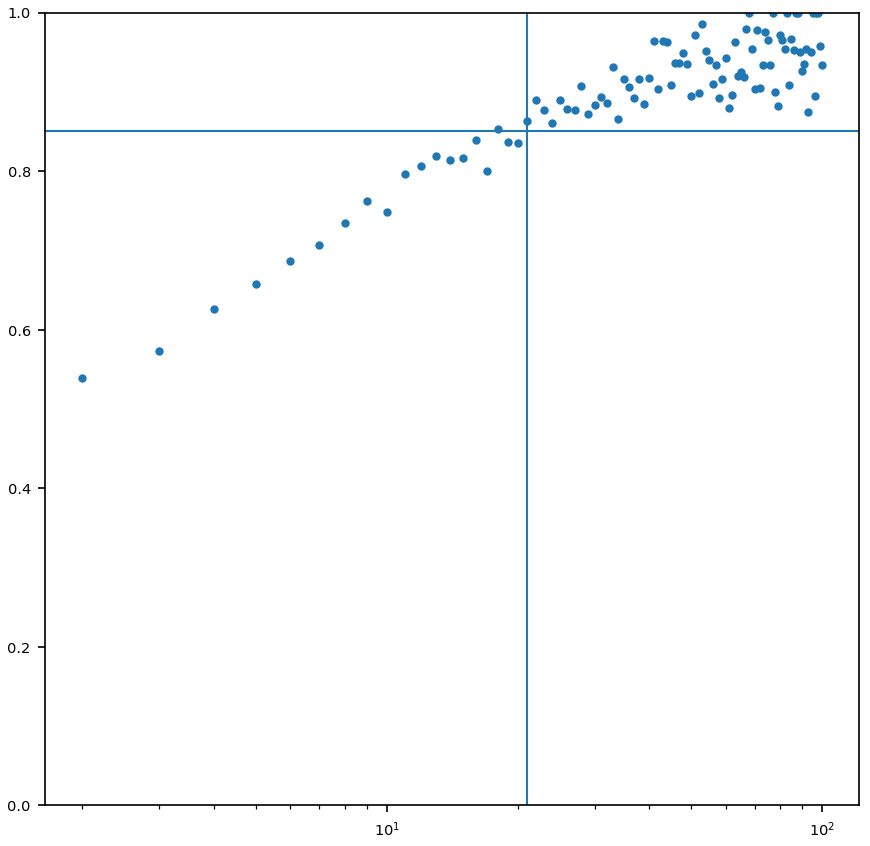

In [ ]:
plt.plot(packages_by_number_of_contributor['Active'][1:100],'.')
plt.ylim(0,1)
plt.xscale('log')
plt.axvline(21)
plt.axhline(0.85)
plt.show()

### Owners with most popular packages

In [ ]:
owners_with_most_packages = filtered_packages.groupby('Owner').agg({
    'Count': 'count',
    'Owner Dependent Count': 'max',
    'Active': 'mean'
}).sort_values('Count',ascending=False)

Number of owners with a single package:

In [ ]:
len(owners_with_most_packages[owners_with_most_packages['Count'] == 1])

15222

In [ ]:
len(filtered_packages)

50232

There are thus about 35,000 packages from owners with at least two popular packages. These owners are only about 7,000:

In [ ]:
owners_with_two_or_more_packages = owners_with_most_packages[owners_with_most_packages['Count'] > 1]
len(owners_with_two_or_more_packages)

6960

## Fetch more data using GitHub's GraphQL API

In [ ]:
api_token = ''

def send_graphql_request(query):
    headers = {'Authorization': f'token {api_token}'}
    url = 'https://api.github.com/graphql'
    json = {'query':query}
    r = requests.post(url=url, json=json, headers=headers)
    r.raise_for_status() # Abort if unsuccessful request
    return r.json()

### Which packages belong to organizations with multiple members?

The goal is to minimize the total number of requests on packages by not querying for packages belonging to an organization with multiple members. Queries about owners that are not organizations are ulta-fast, and those about organizations are faster when they have less members.

In [ ]:
def build_testorg_graphql_query(imin, owners=owners_with_most_packages):
    query = """
    query {
    """
    if imin + 40 < len(owners):
        next_imin = imin + 40
        isup = next_imin
    else:
        next_imin = None
        isup = len(owners)
    index = owners.index[imin:isup]
    for i, owner in enumerate(index):
        query += """
        request%d: repositoryOwner(login: "%s") {
          ... testorg
        }
        """ % (i, owner)
    query += """
    }
    fragment testorg on RepositoryOwner {
      ... on Organization {
        membersWithRole {
          totalCount
        }
      }
    }
    """
    return query, index, next_imin

def save_testorg_result(json, index, owners=owners_with_most_packages):
    data = json['data']
    i = 0
    while f'request{i}' in data:
        result = data[f'request{i}']
        if result is not None:
            if 'membersWithRole' in result:
                owners.loc[index[i],'Organization'] = True
                owners.loc[index[i],'Membership Count'] = result['membersWithRole']['totalCount']
            else:
                owners.loc[index[i],'Organization'] = False
        i += 1

In [ ]:
imin = 0
while imin is not None:
    sys.stdout.write(f'imin: {imin}\r')
    sys.stdout.flush()
    query, index, imin = build_testorg_graphql_query(imin)
    json = send_graphql_request(query)
    save_testorg_result(json, index)

In [ ]:
owners_with_most_packages['Membership Count'] = owners_with_most_packages['Membership Count'].astype('UInt16')

In [ ]:
owners_with_most_packages.to_csv('package_owners.csv')

In [ ]:
owners_with_most_packages = pd.read_csv(
    'package_owners.csv',
    index_col = 'Owner',
    dtype = {
        'Count': 'uint8',
        'Owner Dependent Count': 'uint16',
        'Membership Count': 'UInt16'
    }
)

In [ ]:
orgs_with_multiple_members = owners_with_most_packages[owners_with_most_packages['Membership Count'] > 1]
orgs_with_multiple_members

,Count,Owner Dependent Count,Active,Organization,Membership Count
Owner,,,,,
Microsoft,141,24792,0.929078,True,4209
zendframework,99,635,0.949495,True,22
google,94,2376,0.882979,True,2725
mapbox,94,14474,0.851064,True,62
canjs,93,8,0.978495,True,6
rubysl,91,10,0.000000,True,3
spatie,90,146,0.922222,True,9
dart-lang,87,594,1.000000,True,55
symfony,86,4911,0.988372,True,25


About 33% of all popular packages belong to organizations with at least two (public) members, which should make any transition of maintainers easier, although some companies can still neglect some packages the ecosystem relies on.

In [ ]:
remaining_packages = filtered_packages[~filtered_packages['Owner'].isin(orgs_with_multiple_members.index)].copy()
len(remaining_packages)/len(filtered_packages)

0.6607541009714922

### How many collaborators do the remaining packages have?

For the remaining 66% of packages, we are going to fetch the number of assignable users, which is a way of counting the number of collaborators on the repository. Assignable users are either organization members (when the owner is an organization), or collaborators on the repository (possibly with only read-access, although GitHub's default for new collaborators is write-access). The collaborators do not necessarily have the credentials to publish new versions of the packages, but these are the people closest to the package's maintainer, and which are most likely to be able to get the required credentials if the maintainer needs to step down. Packages with a single assignable user are the most problematic ones.

In [ ]:
def build_collaborators_graphql_query(imin, packages=remaining_packages):
    query = """
    query {
    """
    if imin + 35 < len(packages):
        next_imin = imin + 35
        isup = next_imin
    else:
        next_imin = None
        isup = len(packages)
    index = packages.index[imin:isup]
    for i, repository in enumerate(index):
        owner, name = repository.split('/',maxsplit=1)
        query += """
        request%d: repository(owner: "%s", name: "%s") {
          ... collaborators
        }
        """ % (i, owner, name)
    query += """
    }
    fragment collaborators on Repository {
      assignableUsers {
        totalCount
      }
    }
    """
    return query, index, next_imin

def save_collaborators_result(json, index, packages=remaining_packages):
    data = json['data']
    i = 0
    while f'request{i}' in data:
        result = data[f'request{i}']
        if result is not None:
            packages.loc[index[i],'Collaborators Count'] = result['assignableUsers']['totalCount']
        i += 1

In [ ]:
imin = 0
while imin is not None:
    sys.stdout.write(f'imin: {imin}\r')
    sys.stdout.flush()
    query, index, imin = build_collaborators_graphql_query(imin)
    json = send_graphql_request(query)
    save_collaborators_result(json, index)

In [ ]:
remaining_packages['Collaborators Count'] = remaining_packages['Collaborators Count'].astype('UInt16')

In [ ]:
remaining_packages.to_csv('package_collaborators_count.csv',columns=['Collaborators Count'])

In [ ]:
remaining_packages = remaining_packages.join(pd.read_csv(
    'package_collaborators_count.csv',
    index_col = 'Repository Name with Owner',
    dtype = {
        'Collaborators Count': 'UInt16'
    }
)).dropna()

In [ ]:
remaining_packages

,Repository Last pushed Timestamp,Repository Size,Repository Contributors Count,Owner,Owner Dependent Count,Count,Active,Collaborators Count
Repository Name with Owner,,,,,,,,
node-opcua/node-opcua,2018-12-18,19259,46,node-opcua,6,53,True,2
govuk-react/govuk-react,2018-11-22,14488,18,govuk-react,4,47,True,14
jamesmfriedman/rmwc,2018-11-29,62510,32,jamesmfriedman,10,37,True,6
cssnano/cssnano,2018-12-22,20755,67,cssnano,18003,36,True,5
rackspace/gophercloud,2018-05-08,9970,75,rackspace,11,33,True,5
KyleAMathews/typefaces,2018-12-23,11784,8,KyleAMathews,211,32,True,1
hshoff/vx,2018-12-11,7426,44,hshoff,33,31,True,4
gophercloud/gophercloud,2018-12-22,6105,1,gophercloud,75,30,True,5
lodash-archive/lodash-cli,2018-02-04,4354,9,lodash-archive,1450,26,True,2


And only 33% of the remaining packages (that were not in organizations with multiple members) actually have multiple collaborators, which leaves a larger number of packages with no one ready to step up if the maintainer is missing.

In [ ]:
len(remaining_packages[remaining_packages['Collaborators Count'] > 1]) / len(remaining_packages)

0.3307163886162905

In [ ]:
remaining_packages[remaining_packages['Collaborators Count'] == 1].join(owners_with_most_packages[['Organization']],on='Owner')

,Repository Last pushed Timestamp,Repository Size,Repository Contributors Count,Owner,Owner Dependent Count,Count,Active,Collaborators Count,Organization
Repository Name with Owner,,,,,,,,,
KyleAMathews/typefaces,2018-12-23,11784,8,KyleAMathews,211,32,True,1,False
marionebl/commitlint,2018-12-08,2601,65,marionebl,1301,25,True,1,False
esdoc/esdoc-plugins,2018-09-29,766,6,esdoc,158,21,True,1,True
haraldk/TwelveMonkeys,2018-09-27,267841,17,haraldk,19,19,True,1,False
Flash3001/Xamarin.Swift3.Support,2018-11-07,491074,2,Flash3001,4,18,True,1,False
retep998/winapi-rs,2018-09-21,18416,114,retep998,906,18,True,1,False
angus-c/just,2018-11-17,20495,38,angus-c,2441,17,True,1,False
ericchiang/k8s,2018-06-06,1306,1,ericchiang,4,17,True,1,False
wiredjs/wired-elements,2018-10-09,725,7,wiredjs,4,17,True,1,True


This is a far larger proportion of packages than those with only one collaborator, and yet, this is still a population at risk, posing a health threat on the ecosystem.

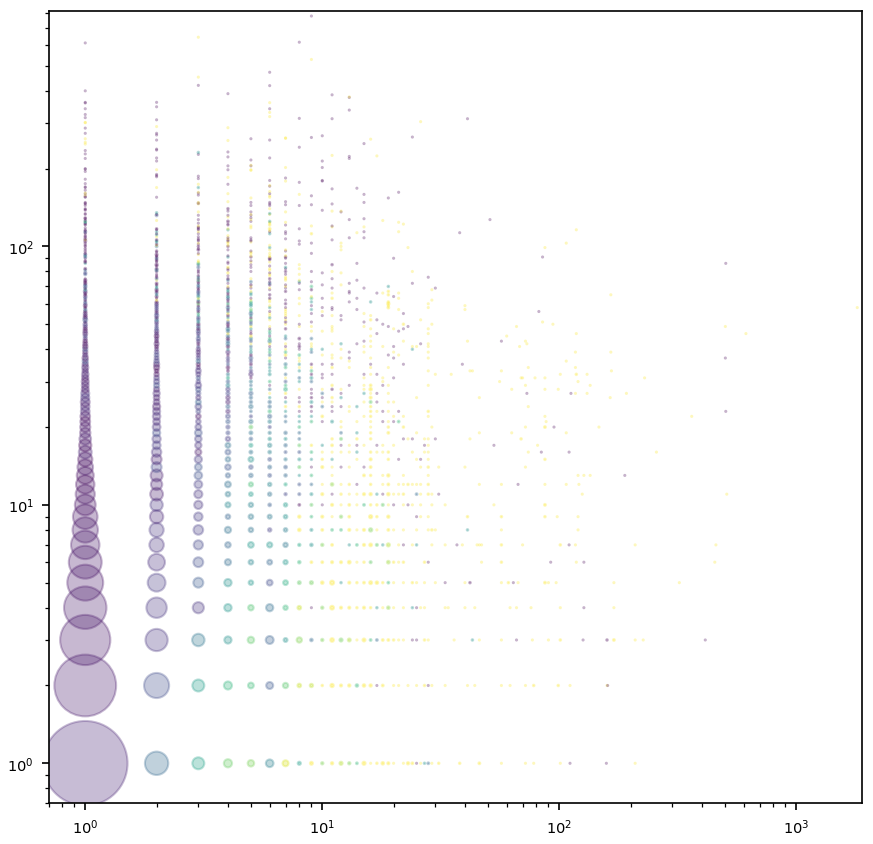

In [ ]:
plot_data = remaining_packages.assign(Count=1).join(owners_with_most_packages[['Organization']],on='Owner').astype({
    'Organization': 'float32'
}).groupby(
    ['Collaborators Count','Repository Contributors Count'],
    as_index=False
).agg({
    'Count': 'count',
    'Organization': 'mean'
})
plt.scatter(
    plot_data['Collaborators Count'],
    plot_data['Repository Contributors Count'],
    s=plot_data['Count'],
    c=plot_data['Organization'],
    marker='.',
    alpha=0.3
)
plt.xlim(left=0.7)
plt.ylim(bottom=0.7)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
single_collaborator_packages = remaining_packages[remaining_packages['Collaborators Count'] == 1]
single_collaborator_packages_by_contributors = single_collaborator_packages.assign(
    Cumsum=1
).groupby('Repository Contributors Count').agg({
    'Cumsum': 'count'
})
single_collaborator_packages_by_contributors['Cumsum'] = len(single_collaborator_packages) - single_collaborator_packages_by_contributors['Cumsum'].cumsum()
single_collaborator_packages_by_contributors

,Cumsum
Repository Contributors Count,
1,15230
2,11715
3,9394
4,7732
5,6542
6,5545
7,4799
8,4204
9,3647


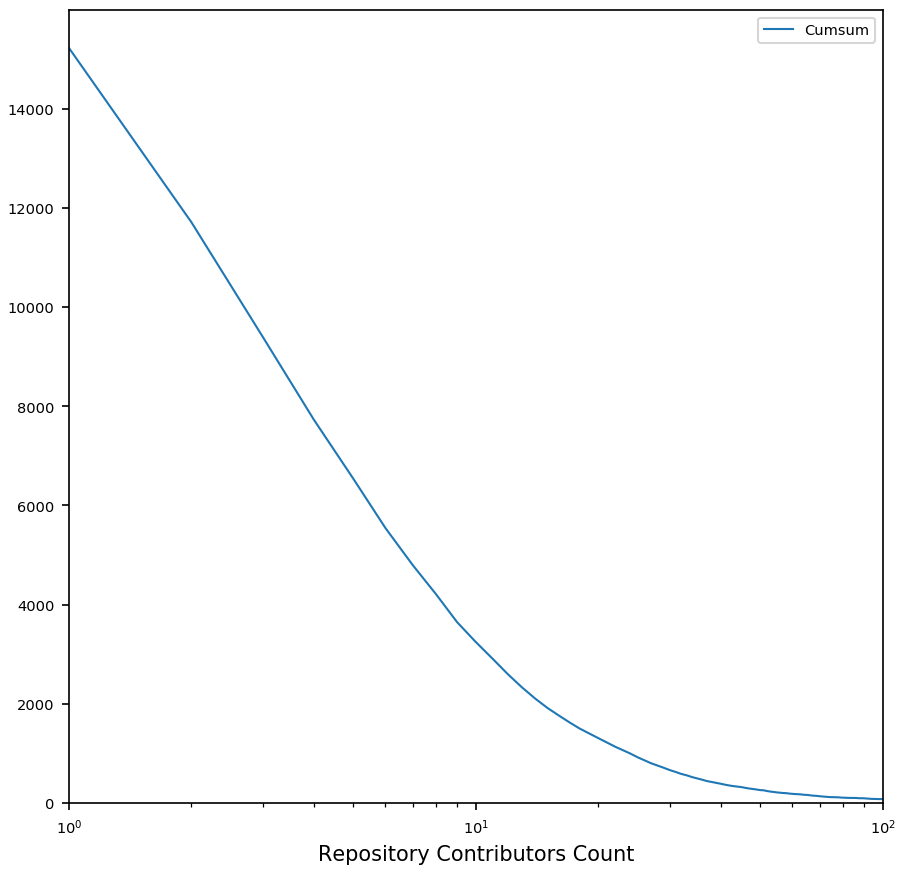

In [ ]:
single_collaborator_packages_by_contributors.loc[:100].plot()
plt.ylim(bottom=0)
plt.xscale('log')
#plt.yscale('log')
plt.show()